# Convergence of mappings

In [1]:
from neurodyn import *
import numpy as np
import matplotlib.pyplot as plt

## reshape

In [8]:
rnn = LowRankRNNParams.new_valentin(p=2, N=1000, phi=sigmoid, exclude_self_connections=False, I_ext=zero)
activity = rnn.phi(rnn.F[:, 0])

In [160]:
bbox = Box.new_bbox(rnn.F)
a, b = 4,4
indices2d = np.vstack([
	# NOTE : we need to clip, because we need equality on the right edge of the last bin : value <= bin[a-1]
	np.clip(np.digitize(rnn.F[:, 0], bins=np.linspace(bbox.xmin, bbox.xmax, a+1)), a_min=0, a_max=a),
	np.clip(np.digitize(rnn.F[:, 1], bins=np.linspace(bbox.ymin, bbox.ymax, b+1)), a_min=0, a_max=b),
]) - 1
indices2d

array([[1, 3, 3, ..., 1, 2, 1],
       [1, 2, 2, ..., 2, 1, 1]])

In [161]:
np.unique(indices2d, axis=1)

array([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
       [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [162]:
indices = np.ravel_multi_index(indices2d, dims=(a,b))
indices[:30]

array([ 5, 14, 14,  9, 10,  7, 11,  9,  9,  9,  6,  9,  9, 10,  1,  9,  6,
       14,  9, 10,  9, 10,  5,  5,  9,  9,  2,  9,  6,  9])

In [163]:
# inverse transformation
np.vstack(np.unravel_index(indices, shape=(a,b)))

array([[1, 3, 3, ..., 1, 2, 1],
       [1, 2, 2, ..., 2, 1, 1]])

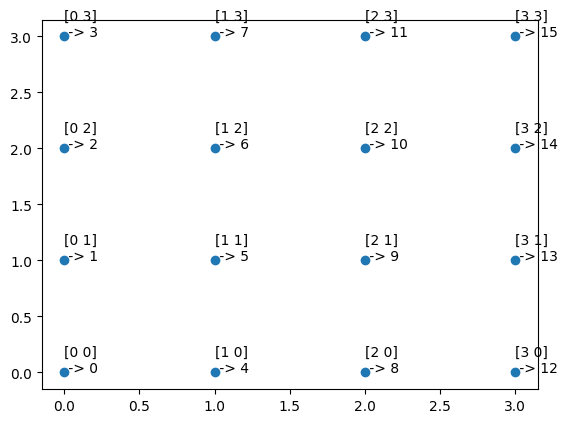

In [202]:
# plt.scatter(*rnn.F.T)
plt.scatter(*np.unique(indices2d, axis=1))
_, idx_unique = np.unique(indices, return_index=True)
for idx2d, idx1d in zip(indices2d.T[idx_unique], indices[idx_unique]):
	plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)

## diagonal

In [197]:
indices_diag = (1/2*(indices2d[0] + indices2d[1])*(indices2d[0]+indices2d[1]+1)+indices2d[0]).astype(int)
# at this stage the diagonals are clipped, so we get something like
# 6  11 17 24
# 3  7  12 18
# 1  4  8  13
# 0  2  5  9
# -> we need to deduplicate and rename
_, idx_inverse = np.unique(indices_diag, return_inverse=True)
indices_diag = np.arange(a*b)[idx_inverse]

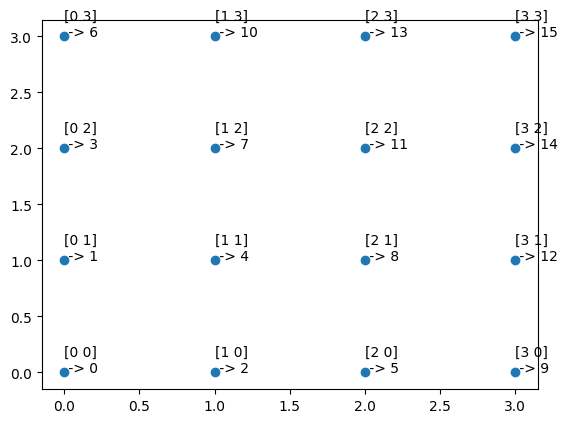

In [199]:
# plt.scatter(*rnn.F.T)
plt.scatter(*np.unique(indices2d, axis=1))
_, idx_unique = np.unique(indices, return_index=True)
for idx2d, idx1d in zip(indices2d.T[idx_unique], indices_diag[idx_unique]):
	plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)

## far

In [276]:
def far_index(F: np.ndarray, n: int, box: Box, offset: int = 0, stride: int = 1) -> np.ndarray:
	indices = np.zeros(len(F), dtype=int)

	box1, box2, box4, box3 = box.split_quadrants()  # NOTE : reordering of the boxes

	mask1 = (box1.xmin <= F[:, 0]) & (F[:, 0] <  box1.xmax) & (box1.ymin <= F[:, 1]) & (F[:, 1] <  box1.ymax)
	mask2 = (box2.xmin <= F[:, 0]) & (F[:, 0] <= box2.xmax) & (box2.ymin <= F[:, 1]) & (F[:, 1] <  box2.ymax)
	mask3 = (box3.xmin <= F[:, 0]) & (F[:, 0] <= box3.xmax) & (box3.ymin <= F[:, 1]) & (F[:, 1] <= box3.ymax)
	mask4 = (box4.xmin <= F[:, 0]) & (F[:, 0] <  box4.xmax) & (box4.ymin <= F[:, 1]) & (F[:, 1] <= box4.ymax)

	if n == 1:
		indices[mask1] = offset+0*stride
		indices[mask2] = offset+1*stride
		indices[mask3] = offset+2*stride
		indices[mask4] = offset+3*stride
		return indices

	indices[mask1] = far_index(F[mask1, :], n-1, box1, offset=offset+0*stride, stride=stride*4)
	indices[mask2] = far_index(F[mask2, :], n-1, box2, offset=offset+1*stride, stride=stride*4)
	indices[mask3] = far_index(F[mask3, :], n-1, box3, offset=offset+2*stride, stride=stride*4)
	indices[mask4] = far_index(F[mask4, :], n-1, box4, offset=offset+3*stride, stride=stride*4)
	return indices

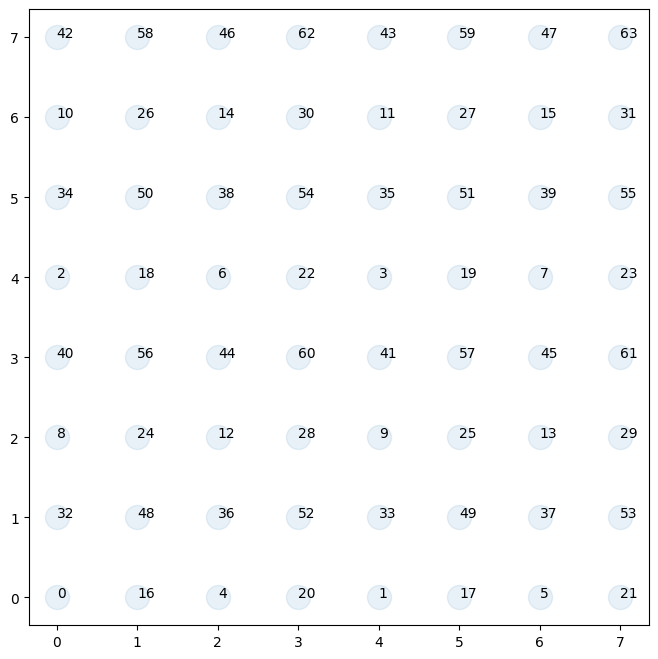

In [285]:
bbox = Box.new_bbox(rnn.F)
F = np.zeros((1000, 2))
F[:, 0] = np.random.default_rng(42).uniform(bbox.xmin, bbox.xmax, len(F))
F[:, 1] = np.random.default_rng(43).uniform(bbox.ymin, bbox.ymax, len(F))
n = 3
a, b = 2**n,2**n
indices2d = np.vstack([
	# NOTE : we need to clip, because we need equality on the right edge of the last bin : value <= bin[a-1]
	np.clip(np.digitize(F[:, 0], bins=np.linspace(bbox.xmin, bbox.xmax, a+1)), a_min=0, a_max=a),
	np.clip(np.digitize(F[:, 1], bins=np.linspace(bbox.ymin, bbox.ymax, b+1)), a_min=0, a_max=b),
]) - 1
indices = np.ravel_multi_index(indices2d, dims=(a,b))
indices_far = far_index(F, n=n, box=Box.new_bbox(rnn.F))

plt.figure(figsize=(8,8))
plt.scatter(*np.unique(indices2d, axis=1), s=300, alpha=0.1)
_, idx_unique = np.unique(indices, return_index=True)
for idx2d, idx1d in zip(indices2d.T[idx_unique], indices_far[idx_unique]):
	# plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)
	plt.annotate(f'{idx1d}', xy=idx2d)

## recursive quadrant

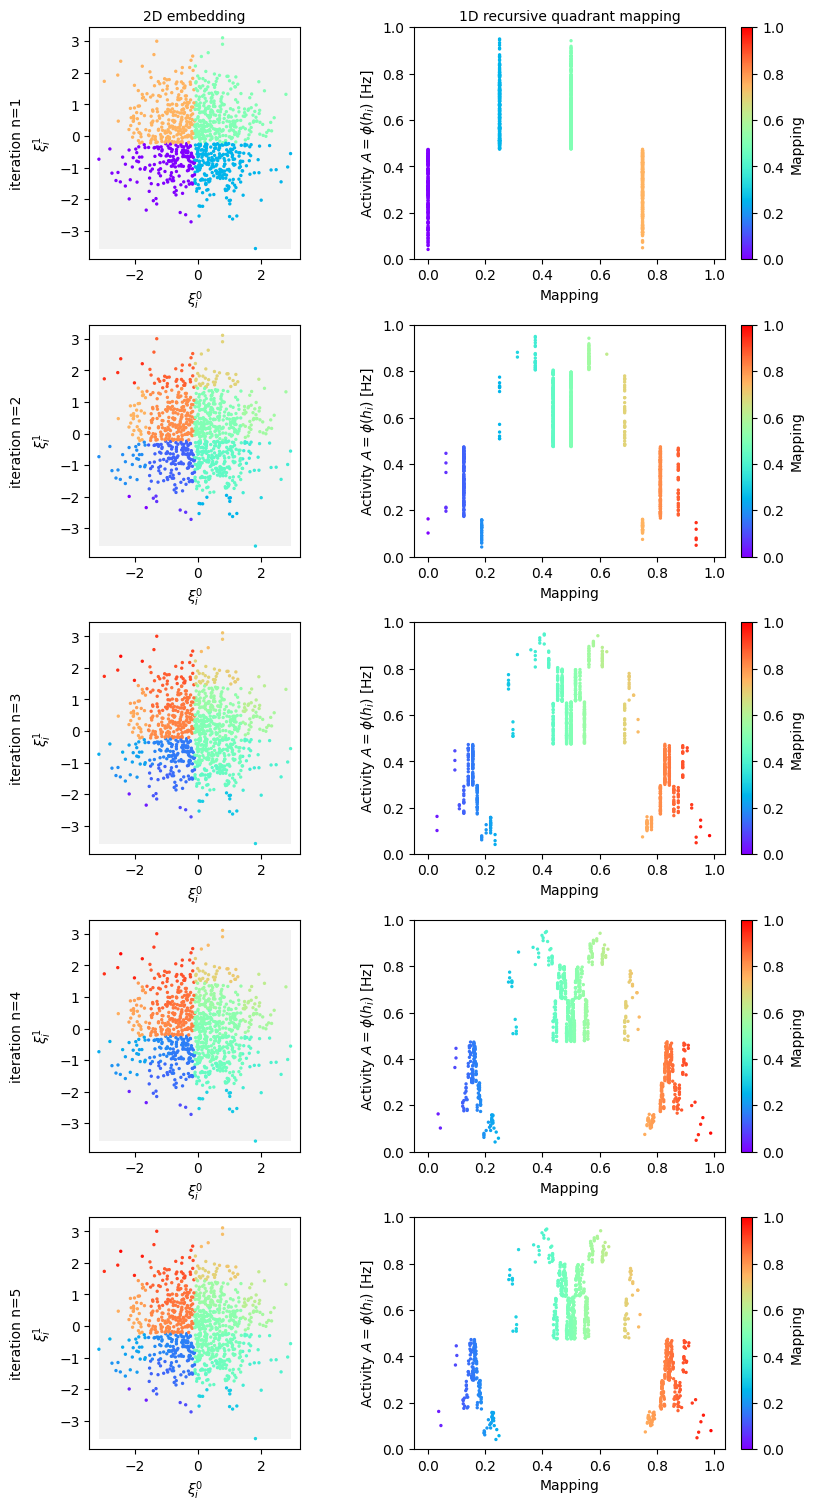

In [9]:
ns = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(ncols=2, nrows=len(ns), figsize=(4*2, 3*len(ns)), constrained_layout=True, sharex='col')

for i, n in enumerate(ns):
	mapping = RecursiveQuadrantMapping(n)(rnn.F)
	bbox = Box(rnn.F[:, 0].min(), rnn.F[:, 0].max(), rnn.F[:, 1].min(), rnn.F[:, 1].max())
	axes[i, 0].add_patch(plt.Rectangle((bbox.xmin, bbox.ymin), bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin, fc='k', alpha=0.05))
	plot_2D_to_1D_mapping(rnn, mapping, activity, figax=(fig, axes[i, :]), cmap='rainbow', s=2, vmin=0, vmax=1)
	axes[i, 0].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].set_ylim((0, 1))

add_headers(fig, row_headers=[f'iteration {n=}' for n in ns])
add_headers(fig, col_headers=['2D embedding', '1D recursive quadrant mapping'])

plt.show()